In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
df = pd.read_csv("df_feat_eng.csv", index_col=0, parse_dates=[0])

In [13]:
df.head()

,holiday,snow_1h,weather_main,weather_description,holiday_binary,temp_celsius,quarter,work_status,snow_1h_cumsum,traffic_volume
2012-10-02 09:00:00,7,0.0,1,24,0,0.673215,4,1,0.0,5545
2012-10-02 10:00:00,7,0.0,1,2,0,0.689412,4,1,0.0,4516
2012-10-02 11:00:00,7,0.0,1,19,0,0.692711,4,1,0.0,4767
2012-10-02 12:00:00,7,0.0,1,19,0,0.700960,4,1,0.0,5026
2012-10-02 13:00:00,7,0.0,1,2,0,0.716107,4,1,0.0,4918


Train, test and val set.

In [18]:
train_size = int(df.shape[0]*0.9)
test_size = int(df.shape[0]*0.95)

In [19]:
train_size, test_size

(43374, 45784)

In [20]:
X_train = df[:train_size].drop("traffic_volume", axis=1)
X_test = df[train_size:test_size].drop("traffic_volume", axis=1)
X_val = df[test_size:].drop("traffic_volume", axis=1)

y_train = df[:train_size]["traffic_volume"]
y_test = df[train_size:test_size]["traffic_volume"]
y_val = df[test_size:]["traffic_volume"]

In [21]:
X_train.shape, X_test.shape, X_val.shape

((43374, 9), (2410, 9), (2410, 9))

**I wont implement hyperparameter optimization**

Metrics 

In [25]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

**LightGBM**

In [22]:
import lightgbm

In [23]:
model = lightgbm.LGBMRegressor()

model.fit(X_train, y_train)

In [37]:
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(preds, y_test))
r2 = r2_score(preds, y_test)
print(f"RMSE Score = {rmse}\nR2 Score = {r2}")

RMSE Score = 1584.688788669512
R2 Score = -0.5874921007797598


In [38]:
preds = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(preds, y_val))
r2 = r2_score(preds, y_val)
print(f"RMSE Score = {rmse}\nR2 Score = {r2}")

RMSE Score = 1536.2073004383358
R2 Score = -0.6018307607461255


**I try using rolling.**

In [46]:
df_new = df.drop("traffic_volume", axis=1)[:-1].copy()

In [47]:
df_new["traffic_volume"] = np.roll(df["traffic_volume"], shift=-1)[:-1]

In [49]:
X_train_roll = df_new[:train_size].drop("traffic_volume", axis=1)
X_test_roll = df_new[train_size:test_size].drop("traffic_volume", axis=1)
X_val_roll = df_new[test_size:].drop("traffic_volume", axis=1)

y_train_roll = df_new[:train_size]["traffic_volume"]
y_test_roll = df_new[train_size:test_size]["traffic_volume"]
y_val_roll = df_new[test_size:]["traffic_volume"]

In [50]:
model = lightgbm.LGBMRegressor()

model.fit(X_train_roll, y_train_roll)

LGBMRegressor()

In [51]:
preds = model.predict(X_test_roll)
rmse = np.sqrt(mean_squared_error(preds, y_test_roll))
r2 = r2_score(preds, y_test_roll)
print(f"RMSE Score = {rmse}\nR2 Score = {r2}")

RMSE Score = 1591.285650129939
R2 Score = -0.5958046499869842


Rolling didn't work.

**SVM**

In [52]:
from sklearn.svm import SVR

In [53]:
model = SVR()
model.fit(X_train, y_train)

SVR()

In [54]:
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(preds, y_test))
r2 = r2_score(preds, y_test)
print(f"RMSE Score = {rmse}\nR2 Score = {r2}")

RMSE Score = 1963.5619657907341
R2 Score = -152.65724832583376


___

**KNN**

In [58]:
from sklearn.neighbors import KNeighborsRegressor

In [59]:
model = KNeighborsRegressor()

In [60]:
model.fit(X_train, y_train)

KNeighborsRegressor()

In [61]:
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(preds, y_test))
r2 = r2_score(preds, y_test)
print(f"RMSE Score = {rmse}\nR2 Score = {r2}")

RMSE Score = 1718.5220818412351
R2 Score = -0.485130871706402


___

**Prophet Multivariate**

In [69]:
from fbprophet import Prophet

**Ready dataframe for prophet**

In [71]:
X_train_prophet = X_train.copy()
X_test_prophet = X_test.copy()

y_train_prophet = y_train.copy()
y_test_prophet = y_test.copy()

In [73]:
X_train_prophet["ds"] = X_train_prophet.index
X_train_prophet["y"] = y_train_prophet.values

X_test_prophet["ds"] = X_test_prophet.index
X_test_prophet["y"] = y_test_prophet.values

In [75]:
prophet = Prophet()

In [76]:
for col in X_train_prophet.columns:
    if col not in ["ds", "y"]:
        prophet.add_regressor(col)

In [77]:
prophet.fit(X_train_prophet)
yhat = prophet.predict(X_test_prophet)

/home/ubuntu/.local/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/ubuntu/.local/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/ubuntu/.local/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [86]:
rmse = np.sqrt(mean_squared_error(yhat.yhat, y_test))
r2 = r2_score(yhat.yhat, y_test)

print(f"RMSE Score = {rmse}\nR2 Score = {r2}")

RMSE Score = 839.7476260272554
R2 Score = 0.7739608294853647


___

**Deep Learning**

- LSTM

In [88]:
import tensorflow as tf

In [108]:
BATCH_SIZE = 64
BUFFER_SIZE = 100
WINDOW_LENGTH = 24

def window_data(X, Y, window=7):
    '''
    The dataset length will be reduced to guarante all samples have the window, 
    so new length will be len(dataset)-window
    '''
    x = []
    y = []
    for i in range(window-1, len(X)):
        x.append(X[i-window+1:i+1])
        y.append(Y[i])
    return np.array(x), np.array(y)


# Since we are doing sliding, we need to join the datasets again of train and test
X_w = np.concatenate((X_train, X_test))
y_w = np.concatenate((y_train, y_test))

X_w, y_w = window_data(X_w, y_w, window=WINDOW_LENGTH)
X_train_w = X_w[:-len(X_test)]
y_train_w = y_w[:-len(X_test)]
X_test_w = X_w[-len(X_test):]
y_test_w = y_w[-len(X_test):]

# Check we will have same test set as in the previous models, make sure we didnt screw up on the windowing
print(f"Test set equal: {np.array_equal(y_test_w,y_test)}")

train_data = tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((X_test_w, y_test_w))
val_data = val_data.batch(BATCH_SIZE).repeat()

Test set equal: True


In [109]:
dropout = 0.0
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(
        128, input_shape=X_train_w.shape[-2:], dropout=dropout),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='rmsprop', loss='mae')


In [110]:
EVALUATION_INTERVAL = 200
EPOCHS = 15

model_history = model.fit(train_data, epochs=EPOCHS,
                                      steps_per_epoch=EVALUATION_INTERVAL,
                                      validation_data=val_data, validation_steps=50)  # ,callbacks=[tensorboard_callback]) #Uncomment this line for tensorboard support

Epoch 1/15
200/200 [==============================] - 7s 27ms/step - loss: 1942.5950 - val_loss: 1595.4778
Epoch 2/15
200/200 [==============================] - 5s 25ms/step - loss: 1164.0195 - val_loss: 1025.5271
Epoch 3/15
200/200 [==============================] - 5s 25ms/step - loss: 933.5542 - val_loss: 892.5765
Epoch 4/15
200/200 [==============================] - 5s 25ms/step - loss: 955.3276 - val_loss: 936.5294
Epoch 5/15
200/200 [==============================] - 5s 25ms/step - loss: 947.6484 - val_loss: 1590.5681
Epoch 6/15
200/200 [==============================] - 5s 24ms/step - loss: 893.2417 - val_loss: 866.5024
Epoch 7/15
200/200 [==============================] - 5s 25ms/step - loss: 860.9034 - val_loss: 980.4658
Epoch 8/15
200/200 [==============================] - 5s 25ms/step - loss: 887.5732 - val_loss: 825.1120
Epoch 9/15
200/200 [==============================] - 5s 25ms/step - loss: 871.7615 - val_loss: 1095.9452
Epoch 10/15
200/200 [============================

In [111]:
preds = model.predict(X_test_w).reshape(1, -1)[0]
rmse = np.sqrt(mean_squared_error(preds, y_test))
r2 = r2_score(preds, y_test)
print(f"RMSE Score = {rmse}\nR2 Score = {r2}")

RMSE Score = 1190.0669022168363
R2 Score = 0.5992078529329388


**Vector AutoRegression (VAR)**

- https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/

In [112]:
from statsmodels.tsa.vector_ar.var_model import VAR

In [117]:
model = VAR(X_train)
model_fit = model.fit()

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [124]:
preds = model.predict(model_fit.params, end=len(X_test))

In [131]:
preds_df = pd.DataFrame(preds, columns=X_train.columns)

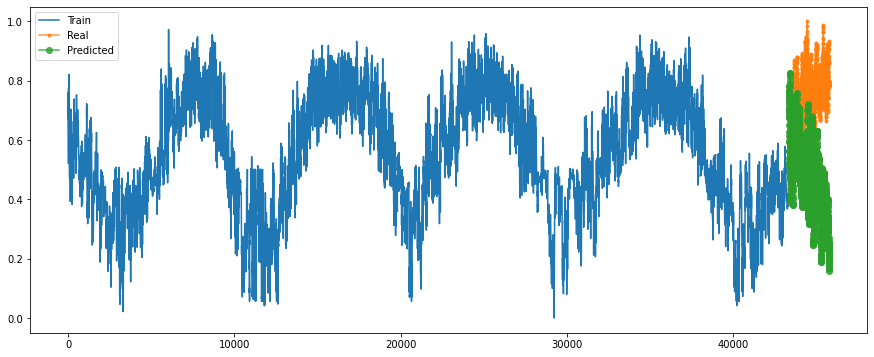

In [159]:
test_temporary = pd.Series(X_test["temp_celsius"].values, range(len(X_train),len(X_train)+len(X_test)))
pred_temporary = pd.Series(preds_df["temp_celsius"].values, range(len(X_train),len(X_train)+len(X_test)))

plt.figure(figsize=(15,6))
plt.plot(X_train["temp_celsius"].values, label="Train")
plt.plot(test_temporary, label="Real",marker=".", alpha=0.8)
plt.plot(pred_temporary, label="Predicted", marker="o", alpha=0.8)
plt.legend()
plt.show()